## Currently this notebook is an illustration for Adonis.

In [2]:
import matplotlib.pyplot as plt
from iqm.qiskit_iqm.fake_backends.fake_adonis import IQMFakeAdonis
from iqm.qiskit_iqm.fake_backends.fake_apollo import IQMFakeApollo
from iqm.benchmarks.entanglement.graph_states import generate_graph_state
from iqm.benchmarks.shadow_utils import *
from qiskit import ClassicalRegister, transpile
from iqm.qiskit_iqm.iqm_transpilation import optimize_single_qubit_gates
from rustworkx.visualization import mpl_draw
from rustworkx import spring_layout

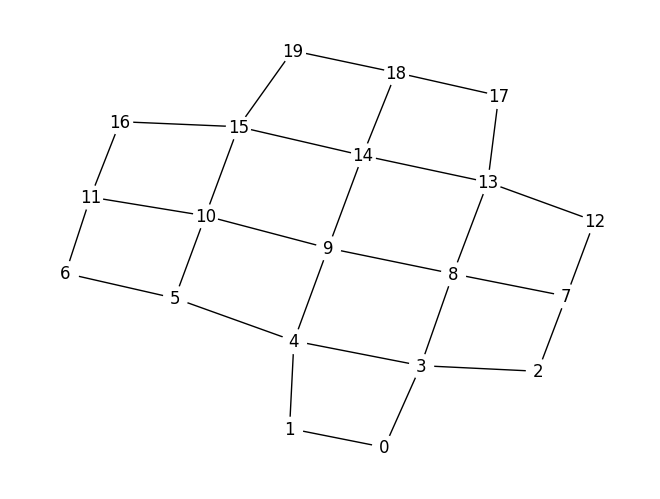

In [34]:
## initiate the backend
# import os
# from iqm.qiskit_iqm import IQMProvider
# os.environ["IQM_TOKEN"] = "fwBucKQFFBYvcynSpatCvgEEEt0faj4RVc7P45XtXUMGdgTJ0WV9L4AAMQzHVeFl"
# QPU = 'pyrite'
# #iqm_server_url = "https://pluto.mx05.iqm.fi/cocos"
#
# if QPU == 'aphrodite':
#     iqm_server_url = "https://fqcp3-host1.xld09.iqm.fi/cocos"
#     provider = IQMProvider(iqm_server_url)
#     backend = provider.get_backend()
#     layout = [1,5,4,6,11]
#     reduced_coupling_map = backend.coupling_map.reduce(mapping=layout)
#     sub_system = list(reduced_coupling_map)
# else:
#     iqm_server_url = 'https://cocos.resonance.meetiqm.com/' + QPU
#     provider = IQMProvider(iqm_server_url)
#     backend = provider.get_backend()


backend = IQMFakeApollo()
cmap = backend.coupling_map
mpl_draw(cmap.graph.to_undirected(multigraph=False), arrows=True, with_labels=True, node_color='w', pos=spring_layout(backend.coupling_map.graph, num_iter=200))

In [35]:
from collections import defaultdict

def find_maximal_edge_set(graph):
    # Build adjacency list representation of the graph
    adjacency = defaultdict(set)
    for u, v in graph:
        adjacency[u].add(v)
        adjacency[v].add(u)

    # Function to get neighboring nodes of an edge
    def get_edge_neighbors(edge):
        u, v = edge
        return (adjacency[u] | adjacency[v]) - {u, v}

    remaining_edges = set(graph)  # Keep track of remaining edges
    iterations = []  # Store the edges chosen in each iteration

    while remaining_edges:
        current_iteration = set()  # Edges chosen in this iteration
        used_nodes = set()  # Nodes already used in this iteration

        for edge in list(remaining_edges):
            u, v = edge
            # Check if the edge is disconnected from already chosen edges
            if u in used_nodes or v in used_nodes:
                continue
            
            # Get neighboring nodes of this edge
            edge_neighbors = get_edge_neighbors(edge)
            
            # Check if any neighbor belongs to an edge already in this iteration
            if any(neighbor in used_nodes for neighbor in edge_neighbors):
                continue
            
            # Add the edge to the current iteration
            current_iteration.add(edge)
            used_nodes.update([u, v])

        # Add the chosen edges to the result
        iterations.append(list(current_iteration))
        remaining_edges -= current_iteration  # Remove chosen edges from the remaining edges

    return iterations

In [49]:
def get_neighbors_of_edges(edges, graph_edges):
    """
    Given a list of edges and a graph, return all neighboring nodes of the edges.
    """
    neighboring_nodes = set()  
    nodes_in_edges = set()     

    for u, v in edges:
        nodes_in_edges.add(u)
        nodes_in_edges.add(v)

    for x, y in graph_edges:
        if x in nodes_in_edges:
            neighboring_nodes.add(y)
        if y in nodes_in_edges:
            neighboring_nodes.add(x)
    neighboring_nodes -= nodes_in_edges

    return list(neighboring_nodes)



In [50]:
def project_neighbouring_qubits(qc, num_cregs, meas_qubit):
    qc_copy = qc.copy()
    qc_copy.barrier()
    register = ClassicalRegister(num_cregs)
    qc_copy.add_register(register)
    for idx, iq in enumerate(meas_qubit):
        qc_copy.measure(iq, register[idx])
    return qc_copy


In [51]:
def alt_edge_neighbors(edges):
    for pair in edges:
        backend.coupling_map.neighbors(q)

In [52]:
num_qubits = backend.num_qubits
#new_cmap = [v for i, v in enumerate(list(cmap)) if i % 2 == 0]
new_cmap = list(cmap.graph.to_undirected(multigraph=False).edge_list())
qc = generate_graph_state(list(range(num_qubits)), backend=backend)

## store state_vector
# import qiskit.quantum_info as qi
# stv_graph = np.array(qi.Statevector.from_instruction(qc))
# rho_graph = np.einsum('i, j -> ij', np.conjugate(stv_graph.T), stv_graph)

run_iterations = find_maximal_edge_set(new_cmap)
num_iterations = len(run_iterations)
projected_nodes = [get_neighbors_of_edges(list(x), new_cmap) for x in run_iterations]
qc_list = [project_neighbouring_qubits(qc, len(x), x) for x in projected_nodes]

In [53]:
run_iterations

[[(10, 11), (12, 13), (3, 4), (18, 19)],
 [(15, 16), (8, 3), (17, 18), (5, 6)],
 [(0, 1), (8, 9), (15, 19), (11, 6)],
 [(0, 3), (7, 12), (16, 11), (9, 14)],
 [(13, 14), (4, 5), (7, 2)],
 [(1, 4), (7, 8), (15, 14)],
 [(17, 13), (9, 4)],
 [(9, 10), (2, 3)],
 [(8, 13), (10, 5)],
 [(15, 10)],
 [(18, 14)]]

In [54]:
projected_nodes

[[0, 1, 2, 5, 6, 7, 8, 9, 14, 15, 16, 17],
 [0, 2, 4, 7, 9, 10, 11, 13, 14, 19],
 [3, 4, 5, 7, 10, 13, 14, 16, 18],
 [1, 2, 4, 6, 8, 10, 13, 15, 18],
 [1, 3, 6, 8, 9, 10, 12, 15, 17, 18],
 [0, 2, 3, 5, 9, 10, 12, 13, 16, 18, 19],
 [1, 3, 5, 8, 10, 12, 14, 18],
 [0, 4, 5, 7, 8, 11, 14, 15],
 [3, 4, 6, 7, 9, 11, 12, 14, 15, 17],
 [5, 9, 11, 14, 16, 19],
 [9, 13, 15, 17, 19]]

In [55]:
for q in qc_list:
    print(q)

           ┌────────────┐┌────────┐                                  ░ ┌─┐   »
  q_0 -> 0 ┤ R(π/2,π/2) ├┤ R(π,0) ├─■──────────────■─────────────────░─┤M├───»
           ├────────────┤├────────┤ │              │                 ░ └╥┘┌─┐»
  q_1 -> 1 ┤ R(π/2,π/2) ├┤ R(π,0) ├─■──────────────┼────────■────────░──╫─┤M├»
           ├────────────┤├────────┤                │        │        ░  ║ └╥┘»
  q_2 -> 2 ┤ R(π/2,π/2) ├┤ R(π,0) ├────■───────────┼──■─────┼────────░──╫──╫─»
           ├────────────┤├────────┤    │           │  │     │        ░  ║  ║ »
  q_3 -> 3 ┤ R(π/2,π/2) ├┤ R(π,0) ├─■──┼────────■──■──■─────┼────────░──╫──╫─»
           ├────────────┤├────────┤ │  │        │           │        ░  ║  ║ »
  q_4 -> 4 ┤ R(π/2,π/2) ├┤ R(π,0) ├─■──┼────────┼──■─────■──■────────░──╫──╫─»
           ├────────────┤├────────┤    │        │  │     │           ░  ║  ║ »
  q_5 -> 5 ┤ R(π/2,π/2) ├┤ R(π,0) ├────┼──■─────┼──┼──■──■───────────░──╫──╫─»
           ├────────────┤├────────┤    │  │     │  │

In [9]:
Nu = 50 ## number of random unitaries used
Nm = 2**10 ## number of measurements per random unitary
counts_list = []
unitaries_list = []
for circs in qc_list:
    unitaries, rm_circs = haar_shadow_tomography(circs, Nu, list(range(num_qubits)))
    rm_trans = [optimize_single_qubit_gates(transpile(qcc, backend), drop_final_rz=True) for qcc in rm_circs]

    job = backend.run(rm_trans, shots = Nm)  
    counts = job.result().get_counts()
    counts_list.append(counts)
    unitaries_list.append(unitaries)

# post-processing code 

In [10]:
neighbour_qubits = 3
neigbour_bit_strings = [' ' + format(x, '0'+str(neighbour_qubits)+'b') for x in range(2**neighbour_qubits)] # list of strings of the remaining 3 neighbouring qubits
counts_bit = [] ## counts of the edge of interest in the graph for all possible combination of the neighbouring qubits

for ibit in neigbour_bit_strings:
    counts_group = []
    for iu in range(num_iterations):
        counts_per_batch = []
        for iq in range(len(counts_list[iu])):
            counts_new = {}
            for inm, ist in enumerate(counts_list[iu][iq].keys()):
                if (ist[-4:] == ibit):
                    counts_new[ist[0:5]] = counts_list[iu][iq][ist]
            counts_per_batch.append(counts_new)
        counts_group.append(counts_per_batch)
    counts_bit.append(counts_group)

In [11]:
## construct shadows for each neighbour_bit_string and each edge of interest.
rho_shadows_all_bits = []

for idx, ibit in enumerate(neigbour_bit_strings):
    rho_shadows = []
    for ib in range(num_iterations):
        nqubits = len(run_iterations[ib][0])
        rho = np.zeros((2**nqubits, 2**nqubits), dtype = complex)
        for iu in range(Nu):
            rho += get_shadow(counts_bit[idx][ib][iu], unitaries_list[ib][iu,:,:,:], list(run_iterations[ib][0]))/Nu
        rho_shadows.append(rho)
    rho_shadows_all_bits.append(rho_shadows)

Text(0.5, 0, 'Edges')

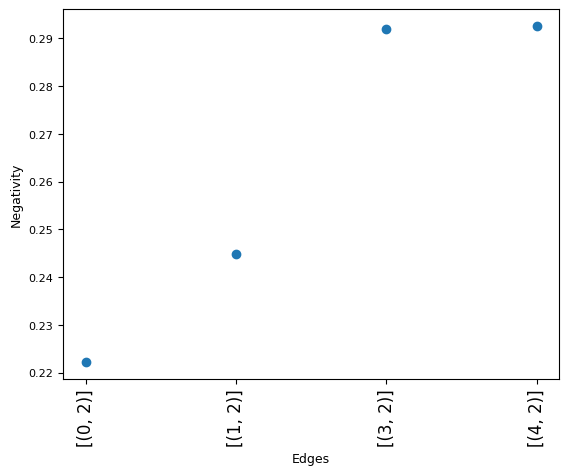

In [12]:
## compute the 2 qubit negativity for each of the neighbour bitstrings and groups
neg = [[np.abs(get_negativity(rho_shadows_all_bits[bits][isys], 1, 1)) for bits in range(2**neighbour_qubits)] for isys in range(num_iterations)]
neg_per_edge = [max(x) for x in neg]
get_index = [x.index(max(x)) for x in neg]
max_neg_dm = [rho_shadows_all_bits[get_index[x]][x] for x in range(num_iterations)]

## plot negativity
plt.scatter(list(range(num_iterations)), neg_per_edge)
plt.xticks(list(range(num_iterations)), run_iterations, fontsize=12, rotation=90)
plt.ylabel('Negativity')
plt.xlabel('Edges')

In [13]:
## construct ideal rdms after the neighbouring strings have been measured
from qiskit.quantum_info import *
proj = np.zeros((3, 2, 2), dtype=complex)
proj[0, :, :] = np.array([[1, 0], [0, 0]])
proj[1, :, :] = np.array([[0, 0], [0, 1]])
proj[2, :, :] = np.array([[1, 0], [0, 1]])
neigbour_bit_strings = [' ' + format(x, '0'+str(neighbour_qubits)+'b') for x in range(2**neighbour_qubits)] 

reduced_dm_list = []
for iq in range(num_iterations):
    projection = 1
    for bits in range(num_qubits):
        if (bits in projected_nodes[iq]):
            bit_index = list(projected_nodes[iq]).index(bits)
            bit_string = neigbour_bit_strings[get_index[iq]]
            ind = int(bit_string[::-1][bit_index])
            projection = np.kron(projection, proj[ind])
        
        else:
            projection = np.kron(projection, proj[2])
    # projection /= np.trace(projection)
    post_selcted_dm = rho_graph@projection
    post_selcted_dm /= np.trace(post_selcted_dm)
    reduced_dm_list.append(np.array(partial_trace(post_selcted_dm, list(projected_nodes[iq]))))

Text(0.5, 0, 'Edges')

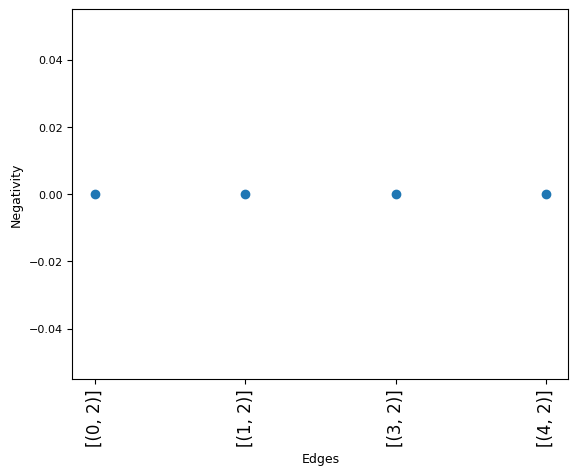

In [14]:
neg_per_edge_ideal = [np.abs(get_negativity(x, 1, 1)) for x in reduced_dm_list]
## plot negativity
plt.scatter(list(range(num_iterations)), neg_per_edge_ideal)
plt.xticks(list(range(num_iterations)), run_iterations, fontsize=12, rotation=90)
plt.ylabel('Negativity')
plt.xlabel('Edges')

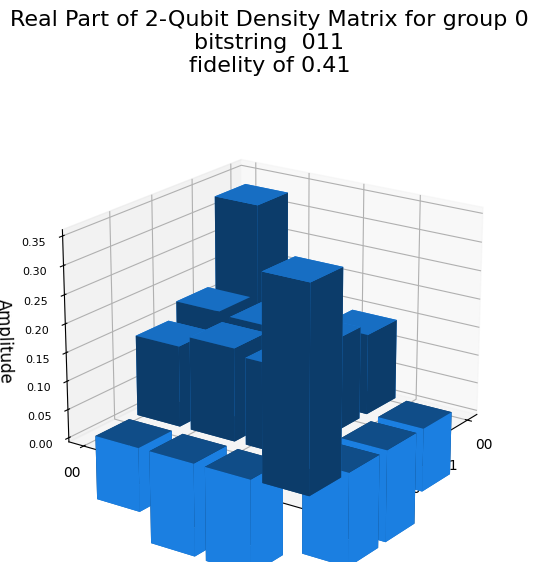

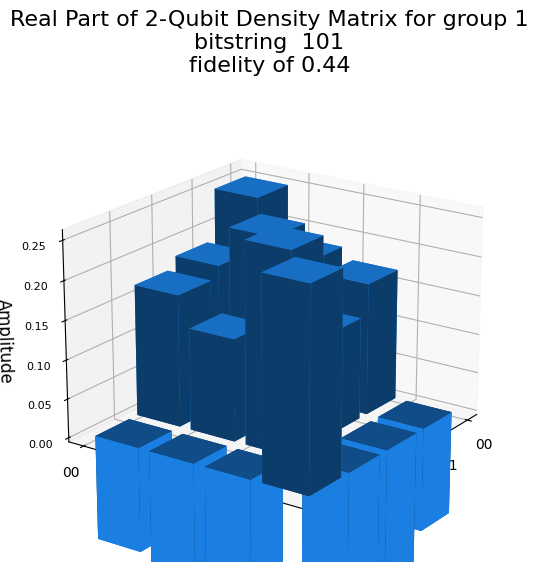

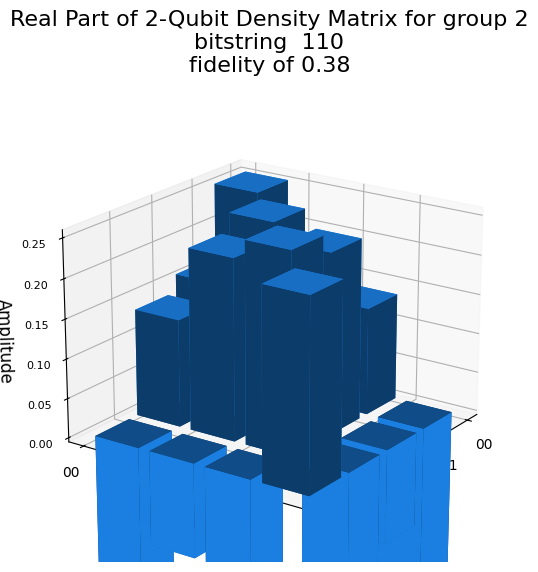

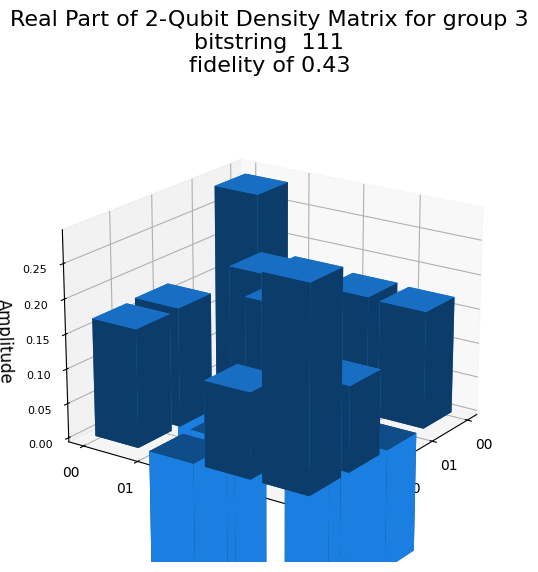

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Bitstring labels for 2-qubit states
bitstrings = ['00', '01', '10', '11']

# Function to create 3D bar plot
def plot_tomography(matrix, title, color):
    n = matrix.shape[0]
    xpos, ypos = np.meshgrid(np.arange(n), np.arange(n), indexing="ij")
    xpos, ypos = xpos.flatten(), ypos.flatten()
    zpos = np.zeros_like(xpos)

    # Heights of the bars (matrix elements)
    heights = matrix.flatten()

    # Bar dimensions
    dx = dy = 0.8

    # Create the figure
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the bars
    ax.bar3d(xpos, ypos, zpos, dx, dy, heights, shade=True, color=color)

    # Set axis labels with bitstrings
    ax.set_xticks(np.arange(n))
    ax.set_yticks(np.arange(n))
    ax.set_xticklabels(bitstrings, fontsize=10)
    ax.set_yticklabels(bitstrings, fontsize=10)

    # Add title and axis labels
    ax.set_title(title, fontsize=16, pad=20)
    ax.set_zlabel("Amplitude", fontsize=12)

    # Set the view angle for better visualization
    ax.view_init(elev=20, azim=35)

    # Show the plot
    #plt.tight_layout()
    plt.show()


# Plot the real part in blue
for iq in range(num_iterations):
    fid = np.trace(max_neg_dm[iq] @ np.array(reduced_dm_list[iq]))
    plot_tomography(np.real(max_neg_dm[iq]), f"Real Part of 2-Qubit Density Matrix for group {iq}\nbitstring {neigbour_bit_strings[get_index[iq]]}\nfidelity of {np.real(fid):.2f}", color="dodgerblue")
    # plot_tomography(np.real(reduced_dm_list[iq]), f"Ideal Real Part of 2-Qubit Density Matrix for group {iq} and bitstring {neigbour_bit_strings[get_index[iq]]}", color="red")